In [7]:
#pip install watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [8]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn

CPython 3.5.2
IPython 6.0.0

numpy 1.12.1
scipy 0.19.0
pandas 0.19.2
matplotlib 2.0.0
sklearn 0.18.1

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.4.59-boot2docker
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [10]:
data_demo = pd.read_csv('/ml/data/weights_heights.csv')

# Реализуйте класс SGDRegressor. Спецификация:
класс наследуется от sklearn.base.BaseEstimator
конструктор принимает параметры eta – шаг градиентного спуска (по умолчанию $10^{-3}$) и n_iter – число проходов по выборке (по умолчанию 10)

также в конструкторе должны создаваться списки mse_ и weights_ для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска

Класс имеет методы fit и predict

Метод fit принимает матрицу X и вектор y (объекты numpy.array), добавляет к матрице X слева столбец из единиц, инициализирует вектор весов w нулями и в цикле с числом итераций n_iter обновляет веса (см. статью), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов w в предназначенные для этого списки.

В конце метод fit создает переменную w_, в которой хранится тот вектор весов, при котором ошибка минимальна

Метод fit должен возвращать текущий экземпляр класса SGDRegressor, т.е. self

Метод predict принимает матрицу X, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом fit вектор весов w_.

In [11]:
from sklearn.metrics import mean_squared_error

class SGDRegressor(BaseEstimator):
    def __init__(self,eta=10**-3,n_iter=10,verbose=0):
        self.eta=eta
        self.n_iter=n_iter
        self.mse_=[]
        self.weights_=[]       
        self.verbose=verbose
        
    def calc_y_pred(self,x):
        return self.weights_[0]+self.weights_[1]*x
        
    def fit(self,X,y):        
        dim=X.shape[0]
        self.weights_=[.0,1.]        
        y_pred=np.zeros(dim)
        self.mse_=0
        
        for n in range(self.n_iter):                        
            for i in range(dim):#прогоняем по рядам                
                nu=self.eta*(y[i]-self.weights_[0]-self.weights_[1]*X[i])                                
                self.weights_[0]+=nu
                self.weights_[1]+=nu*X[i]
                               
                y_pred=list(map(self.calc_y_pred,X))
                
            if self.verbose>0:
                self.mse_=mean_squared_error(y, y_pred)
                print('N',(n+1),': mse_train=',self.mse_)
                
    def predict(self,X):
        return np.apply_along_axis(self.calc_y_pred, 0, X)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


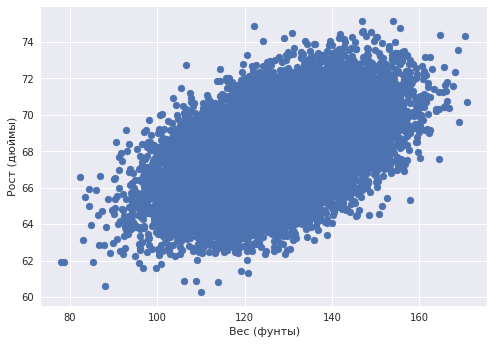

In [12]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес (фунты)')
plt.ylabel('Рост (дюймы)');

In [13]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

#Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

In [14]:
sgd=SGDRegressor()
sgd.fit(X_train_scaled,y_train)

y_pred=sgd.predict(X_valid_scaled)
m1=mean_squared_error(y_valid, y_pred)
print('mse_pred= ',m1)

mse_pred=  2.6758568913


In [15]:
from sklearn.linear_model import LinearRegression 
regr = LinearRegression().fit(X_train_scaled.reshape(-1, 1),y_train)

y_pred=regr.predict(X_valid_scaled.reshape(-1, 1))
m2=mean_squared_error(y_valid, y_pred)
print('mse_pred= ',m2)

print(m1-m2)
print('В каком знаке после разделителя отличаются MSE линейной регрессии и SGDRegressor для отложенной выборки? 3')

mse_pred=  2.67083076767
0.00502612363698
В каком знаке после разделителя отличаются MSE линейной регрессии и SGDRegressor для отложенной выборки? 3


## 1.2. Логистическая регрессия и SGD

In [16]:
print('По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском? 4')

По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском? 4


In [17]:
#конструктор принимает параметры eta – шаг градиентного спуска (по умолчанию $10^{-3}$), 
#n_iter – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
from sklearn.metrics import roc_auc_score

class SGDClassifier(BaseEstimator):
    def __init__(self,eta=10**-3,C=1,n_iter=10,verbose=0):
        self.eta=eta
        self.n_iter=n_iter
        self.verbose=verbose
        self.C=C
        #также в конструкторе должны создаваться списки loss_ и weights_ для отслеживания значений логистических потерь и 
        #вектора весов по итерациям градиентного спуска
        self.loss_=[]
        self.weights_=[]
    
    def sigma(self, z):
        lim=100
        z = z.flatten()
        z[z > lim] = lim
        z[z < -lim] = -lim
        return 1. / (1 + np.exp(-z))
    
    def calcSigma(self,X):
        return self.sigma(np.dot(self.weights_.T,X))[0]
    
    def fit(self,X,y):
        eta=self.eta
        n_iter=self.n_iter        
        C=self.C
        y_true = list(map(lambda y: 0 if y<0 else 1 ,y))#Класс объекта
        
        
        dim=X.shape[0]        
        _X=np.insert(X,0,np.ones(dim),1)
        dim1=_X.shape[1]
        self.weights_=np.zeros(dim1)
        y_scores=np.zeros(dim)
        y_pred=np.zeros(dim)
        self.loss_=np.zeros(n_iter)
        
                
        for n in range(n_iter):            
            for i in range(dim):
                gradient=self.sigma(-1*np.dot(y[i]*self.weights_.T,_X[i]))[0]
                delta=[C*y[i]*xx*gradient-(0 if j==0 else 1)*ww for xx, ww,j in zip(_X[i], self.weights_,range(dim1))]
                self.weights_=np.array([ww+eta*dt for ww,dt in zip(self.weights_,delta)])
                
                #предсказание                
                y_scores[i]=self.calcSigma(_X[i])
                y_pred[i]=-1 if y_scores[i]<0.5 else 1
               
            self.loss_[n]=log_loss(y, y_pred)
            if self.verbose>0:
                aUC_ROC=roc_auc_score(y, y_pred)
                print ('N',(n+1),'AUC_ROC=' , aUC_ROC)                
        
    #Метод predict_proba принимает матрицу X, добавляет к ней слева столбец из единиц и 
    #возвращает матрицу прогнозов модели (такую же, какую возвращают методы predict_proba моделей sklearn), 
    #используя созданный методом fit вектор весов w_
    def predict_proba(self,X):
        dim=X.shape[0]
        _X=np.insert(X,0,np.ones(dim),1)
        y_scores=np.zeros(dim)
        
        for i in range(dim):
            y_scores[i]=self.calcSigma(X[i])
        
        return y_scores
    
    #Метод predict вызывает метод  predict_proba и возвращает вектор ответов: 
    #-1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
    def predict(self,X):
        y_scores=self.predict_proba(X)
        y_pred=list(map(lambda y: -1 if y<0.5 else 1 ,y_scores))
        
        return y_pred
        

### Проверим SGDClassifier на данных UCI по раку молочной железы.

In [18]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]


#Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

N 1 AUC_ROC= 0.995951417004
N 2 AUC_ROC= 0.996688741722
N 3 AUC_ROC= 0.996688741722
N 4 AUC_ROC= 0.996688741722
N 5 AUC_ROC= 1.0
N 6 AUC_ROC= 0.997975708502
N 7 AUC_ROC= 1.0
N 8 AUC_ROC= 0.996688741722
N 9 AUC_ROC= 0.997975708502
N 10 AUC_ROC= 1.0


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


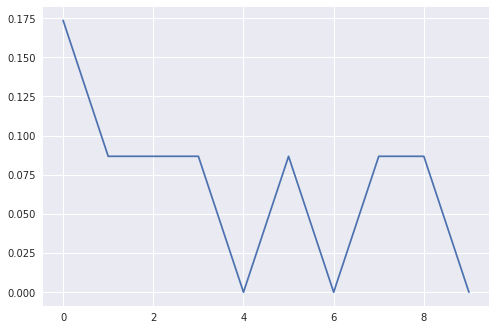

In [19]:
#cls=SGDClassifier(verbose=0, eta=10**-4,C=0.01,n_iter=25)
#cls=SGDClassifier(verbose=0, C=1)
cls=SGDClassifier(verbose=1,C=1000)
cls.fit(X_train_scaled,y_train)#,show_index=0

plt.plot(cls.loss_)

In [20]:
#получаем список показателей которые сильнее всего влияют на предсказания
ww=list(map(lambda x: abs(x),cls.weights_[1:]))
print ('3. Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели SGDClassifier?',cancer.feature_names[list(ww).index(np.max(ww))])

3. Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели SGDClassifier? worst concavity


# 1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

In [22]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [23]:
# поменяйте путь к файлу
reviews_train = load_files("/ml/data/imdb_reviews/aclImdb/train")
text_train, y_train = reviews_train.data, reviews_train.target


reviews_test = load_files("/ml/data/imdb_reviews/aclImdb/test")
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных CountVectorizer, считая биграммы, то есть перейдем к 
разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей
выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [26]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

CPU times: user 30.3 s, sys: 0 ns, total: 30.3 s
Wall time: 30.3 s


In [27]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

In [30]:
clf=SGDClassifier(random_state=17)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

aUC_ROC=roc_auc_score(y_test, y_pred)
print ('AUC_ROC=' , aUC_ROC)

AUC_ROC= 0.88288


In [31]:
print('Чем sklearn-реализация стохастического классификатора более продвинута, чем SGDClassifier, который мы реализовали? Отметьте все подходящие варианты.')
print('Изменяемый шаг градиентного спуска - да')
print('Реализован линейный SVM - да')
print('Реализована ранняя остановка во избежание переобучения -?')
print('Есть распараллеливание по процессорам - да')
print('Можно обучать LASSO')
print('Поддерживается онлайн-обучение деревьев решений')
print('Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному) -да')

Чем sklearn-реализация стохастического классификатора более продвинута, чем SGDClassifier, который мы реализовали? Отметьте все подходящие варианты.


In [34]:
%%time
#Проведите 100 итераций SGD-логрегрессии (опять random_state=17) 
#на той же выборке. Опять замерьте время обучения модели и обратите внимание, 
#насколько оно меньше, чем время обучения логистической регрессии.


clf=SGDClassifier(random_state=17,n_iter=100,loss='log')
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

aUC_ROC=roc_auc_score(y_test, y_pred)
print ('AUC_ROC=' , aUC_ROC)

AUC_ROC= 0.89444
CPU times: user 7.15 s, sys: 0 ns, total: 7.15 s
Wall time: 7.15 s


In [35]:
print('1.5. В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора Sklearn с логистической функцией потерь? - 2')

1.5. В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора Sklearn с логистической функцией потерь? - 2
